In [2]:
source('c:/users/tom/pycharmprojects/nyu-research/ts.R')

Warning message:
"package 'zoo' was built under R version 3.3.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'forecast' was built under R version 3.3.3"

In [3]:
time_index <- function(df){
  #indexes a dataframe by 30 days and 24 hours
  
  times = data.frame()
  for (d in 1:30){
    for (h in 0:23){
      times = rbind(times, c(d, h, 0))
    }
  }
  colnames(times) = c('day', 'hour', 'tweets')
  colnames(df) = c('day', 'hour', 'tweets')
  merged = merge(times, df, by=c('day', 'hour'), all='TRUE')
  merged[is.na(merged)] = 0
  merged['tweets'] = pmax(merged$tweets.x,merged$tweets.y)
  return (merged)
}

In [4]:
preprocessing_df <- function(ts, total, thres=5000){
  
  # removes rows with low observations and locfs them
  # returns time series and total time series, as a list
  
  df = time_index(data.frame(ts))
  df_total = time_index(data.frame(total))
  
  missing = df_total[,'tweets']<thres
  print(which(missing))
  df_total[missing, 'tweets'] <- NA
  df[missing,] <-NA
  df_total = na.locf(df_total[,'tweets'])
  df_filled = (na.locf(df[, ncol(df)]))
  
  return(list(series=df_filled, total=df_total))
}

In [65]:
time_index_6 <- function(df){
  #indexes a dataframe by 30 days and 24 hours in 6 hour blocks
  for (i in 1:nrow(df)){
      df[i, 'hour'] <- 6*(df[i, 'hour']%/%6)
  }
  times = data.frame()

  for (d in 1:30){
    for (h in c(0,6,12,18)){
    tot = sum(df[(24*(d-1) + h+1):(24*(d-1)+h+6), 3])
    times = rbind(times, c(d, h, tot))
    }
  }
    colnames(times) = c('day', 'hour', 'tweets')
#   merged = merge(times, df, by=c('day', 'hour'), all='TRUE')
#   merged[is.na(merged)] = 0
#   merged['tweets'] = pmax(merged$tweets.x,merged$tweets.y)
#   return (merged)
    times
}

In [66]:
preprocessing_df_6 <- function(ts, total, thres=5000){
  
  # removes rows with low observations and locfs them
  # returns time series and total time series, as a list
  
  df = time_index_6(data.frame(ts))
  df_total = time_index_6(data.frame(total))
  
  missing = df_total[,'tweets']<thres
  print(which(missing))
  df_total[missing, 'tweets'] <- NA
  df[missing,] <-NA
  df_total = na.locf(df_total[,'tweets'])
  df_filled = (na.locf(df[, ncol(df)]))
  
  return(list(series=df_filled, total=df_total))
}

In [114]:
head(time_index_6(tot))

day,hour,tweets
1,0,17772
1,6,40197
1,12,58417
1,18,56929
2,0,16354
2,6,37406


First we plot and cluster the hourly sampled series for present, current, and shisha, as absolute number of tweets per hour.

In [115]:
plot_all <- function(fcsv, plot_max){
    j_tob <- read.csv(fcsv)
    pres <- j_tob[c(1,2,3)]
    tot <- j_tob[c(1,2,4)]
    new <- preprocessing_df(pres, tot)
    ts_pres <- ts((new$series)[33:(672+32)], frequency=24)
    pres.1 = as.numeric(window(ts_pres, start=c(1, 1), end= c(7, 24)))
    pres.2 = as.numeric(window(ts_pres, start=c(8, 1), end= c(14, 24)))
    pres.3 = as.numeric(window(ts_pres, start=c(15, 1), end= c(21, 24)))
    pres.4 = as.numeric(window(ts_pres, start=c(22, 1), end= c(28, 24)))
    abs_tob = data.frame(pres.1, pres.2, pres.3, pres.4)
    plot_weeks <- function(ts){
    #     week_names = c('June 2-8', 'June 9-15', 'June 16-22', 'June 23-29', 'Sept 1-7', 'Sept 8-14', 'Sept 15-21', 'Sept 22-28')
        week_names = c('J1', 'J2', 'J3', 'J4')
    par(mfrow=c(4,1))
    # outer margin
    par(oma = c(5, 3, 0, 0))

    shade_color <- rgb(0, 0, 190, alpha=50, maxColorValue=255)
    for (col in 1:4){
        # remove space for x-axis
        par(mar = c(0, 8, 0, 0))
        yrange = c(0, plot_max)
        plot(ts[, col], type='l', xaxt='n', ylim=yrange, yaxt='n', ylab='')
        title(cex.lab =3, ylab=week_names[col], line=6)
        axis(2, at=c(0, plot_max %/%3, 2*plot_max %/%3), las = 1, cex.axis=2)
        abline(v=seq(1, 168, by=24), lty=2)

    }

mtext('Total Present Tweets', cex=2, side = 2, outer = TRUE, line = 1)
mtext('Hour of Week (dotted lines at 8am local time)', cex=1.5, side = 1, outer = TRUE, line = 3)
axis(1, labels = c('Tu', 'W', 'Th', 'F', 'Sa', 'Su', 'M'), at=seq(1, 168, by=24), outer=TRUE)

    
}
    plot_weeks(abs_tob)
    
    # dendogram
    weekdays = rep(c('Tu', 'W' ,'Th', 'F', 'Sa', 'Su', 'M'), 4)
    june_days = split_by_day(ts_pres)
    colnames(june_days)=weekdays
    dist = diss(june_days, METHOD = 'EUCL')
    c = agnes(dist, diss=TRUE)
    euc_dend <-function(){
    fviz_dend(c, rect=TRUE, main='', ylab='', xlab='Height', 
              las=1, cex=1.2, cex.lab=1.5, horiz=TRUE)
        #mtext( text='Day of Week', side=2, cex=1.5)
    }
    euc_dend()
    
}


# Absolute number of Present tweets per hour in June

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723


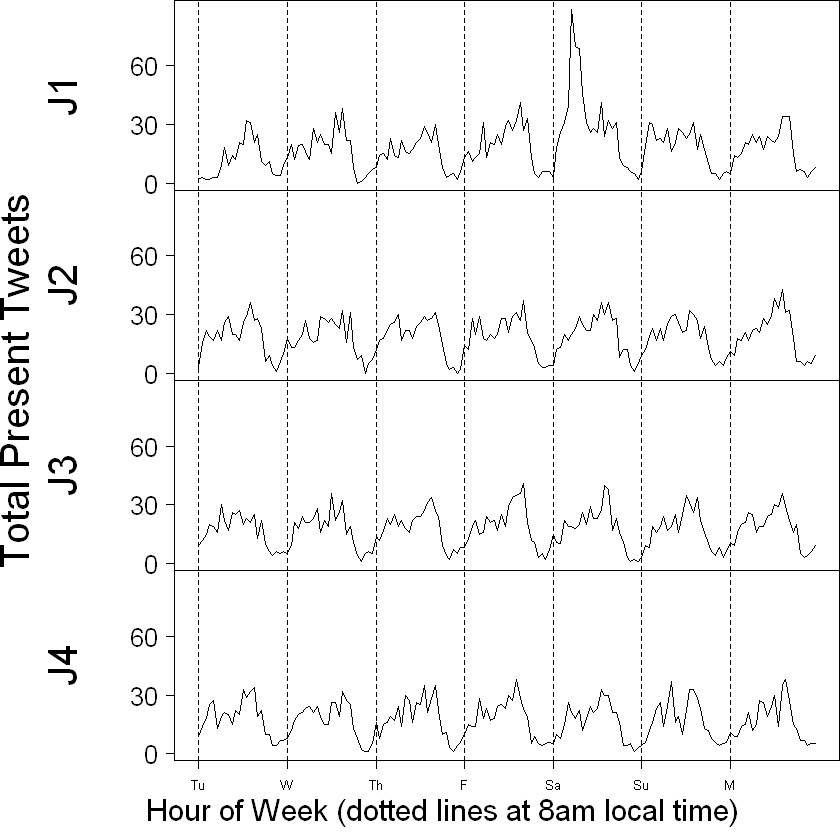

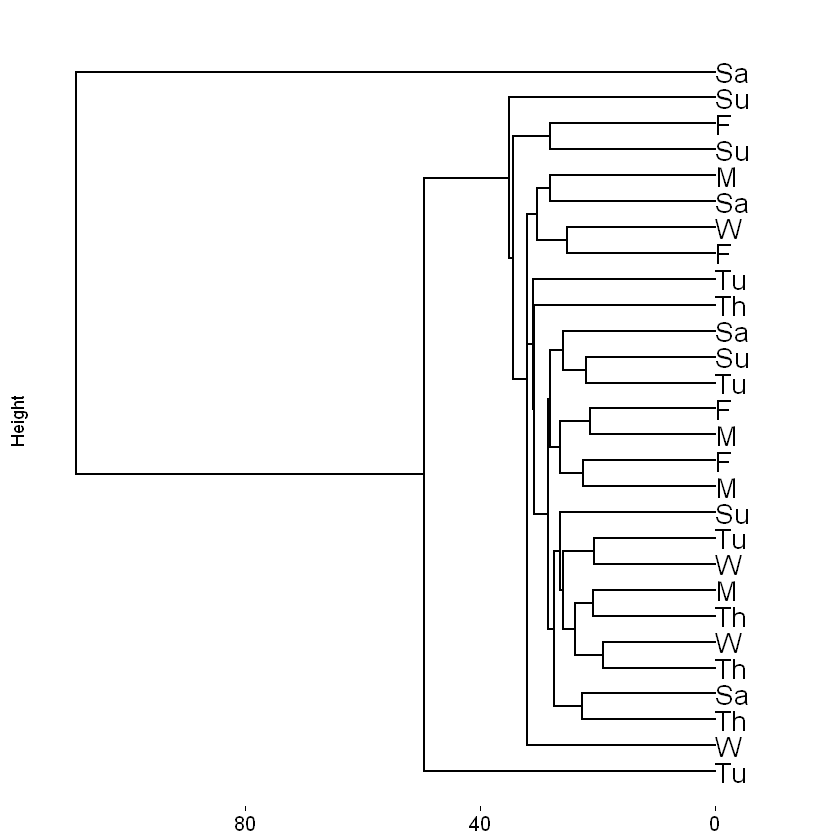

In [109]:

plot_all('c:/users/tom/documents/nyu-test/tob-run/june/summary/summary/present.csv', 90) 

# Absolute number of Current tweets per hour in June

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723


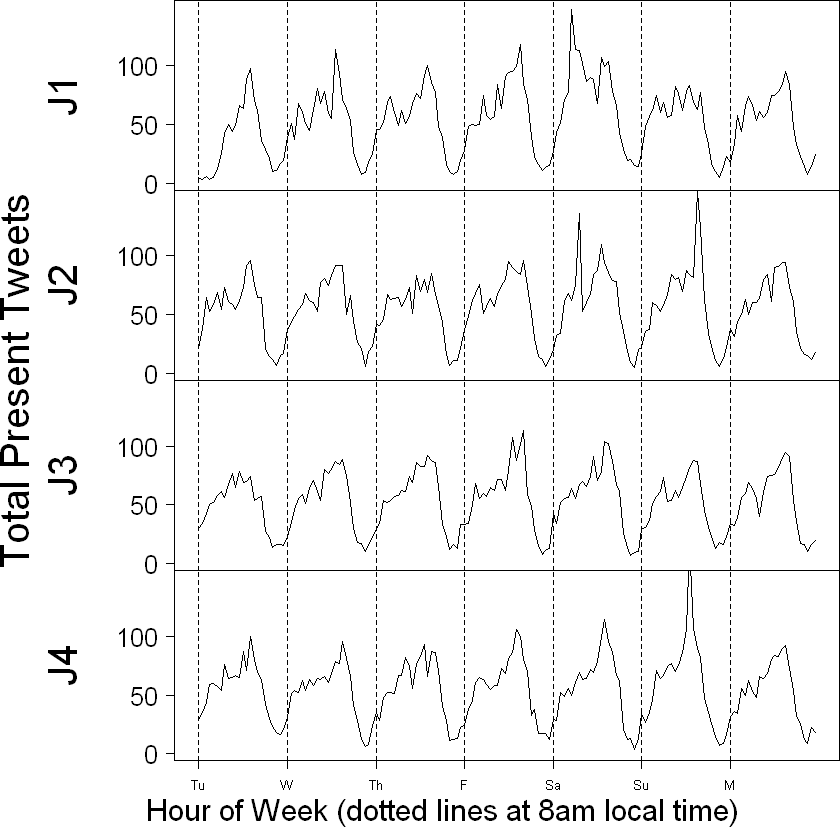

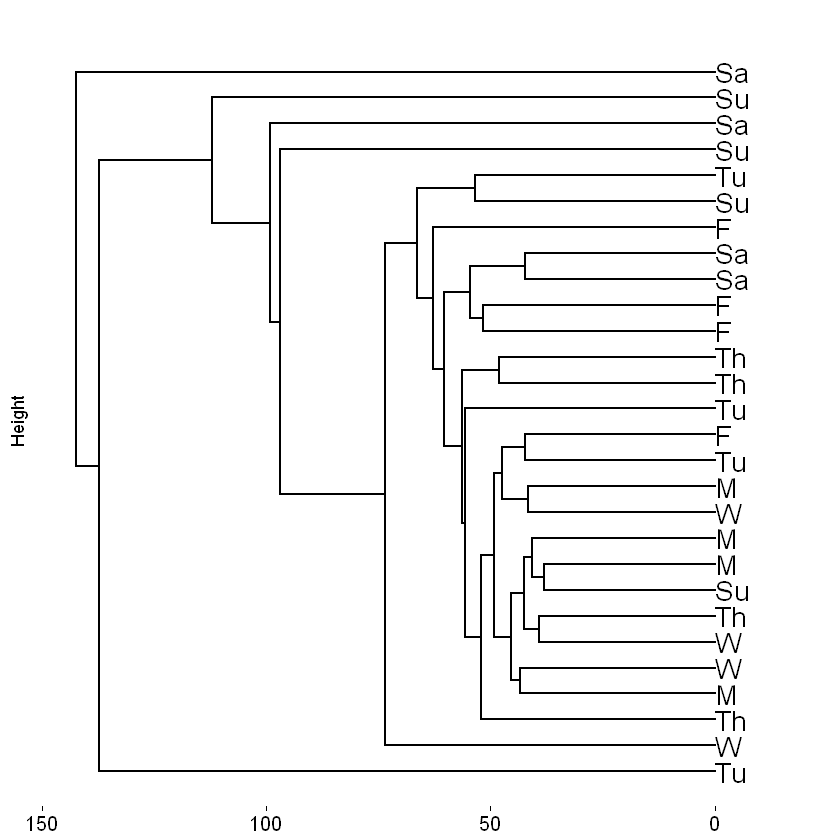

In [112]:

plot_all('c:/users/tom/documents/nyu-test/tob-run/june/summary/summary/current.csv', 150)

# Absolute number of (Shisha & current) tweets per hour in June

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723


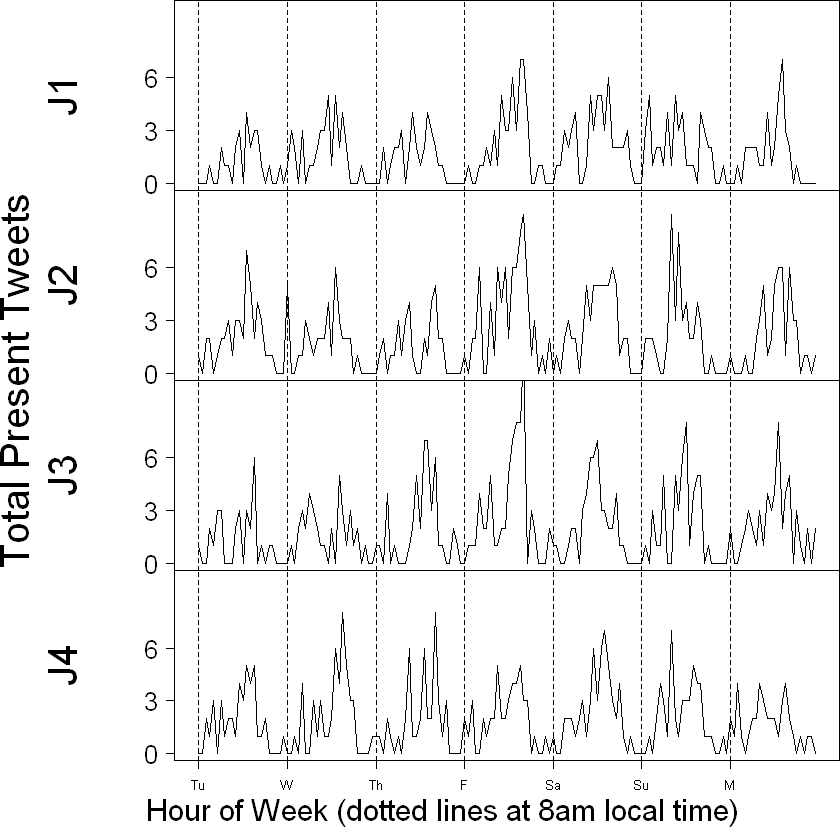

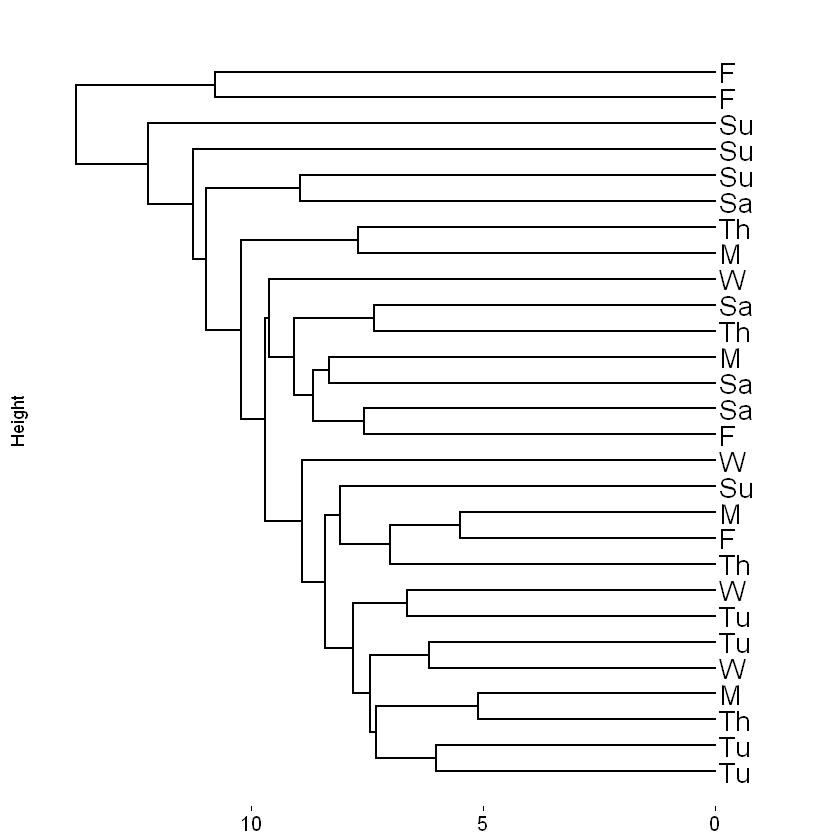

In [108]:
plot_all('c:/users/tom/documents/nyu-test/tob-run/june/summary/summary/shisha.csv', 10)

Now we do the same thing but group into 6 hours periods (12am-5am, 6am-11am, 12pm-5pm, 6pm-11pm, inclusive)

In [98]:
plot_6hour <- function(fcsv, plot_max){
    j_tob <- read.csv(fcsv)
    pres <- j_tob[c(1,2,3)]
    tot <- j_tob[c(1,2,4)]
    new <- preprocessing_df_6(pres, tot)
    ts_pres <- ts((new$series)[5:(4*28+5)], frequency=4)
    pres.1 = as.numeric(window(ts_pres, start=c(1, 1), end= c(7, 4)))
    pres.2 = as.numeric(window(ts_pres, start=c(8, 1), end= c(14, 4)))
    pres.3 = as.numeric(window(ts_pres, start=c(15, 1), end= c(21, 4)))
    pres.4 = as.numeric(window(ts_pres, start=c(22, 1), end= c(28, 4)))
    abs_tob = data.frame(pres.1, pres.2, pres.3, pres.4)
    plot_weeks <- function(ts){
    #     week_names = c('June 2-8', 'June 9-15', 'June 16-22', 'June 23-29', 'Sept 1-7', 'Sept 8-14', 'Sept 15-21', 'Sept 22-28')
    week_names = c('J1', 'J2', 'J3', 'J4')
    par(mfrow=c(4,1))
    # outer margin
    par(oma = c(5, 3, 0, 0))

    shade_color <- rgb(0, 0, 190, alpha=50, maxColorValue=255)
    for (col in 1:4){
        # remove space for x-axis
        par(mar = c(0, 8, 0, 0))
        yrange = c(0, plot_max)
        plot(ts[, col], type='l', xaxt='n', ylim=yrange, yaxt='n', ylab='')
        title(cex.lab =3, ylab=week_names[col], line=6)
        axis(2,  at=c(0, plot_max %/%3,  2*plot_max %/%3), las = 1, cex.axis=2)
        abline(v=seq(1, 28, by=4), lty=2)

    }

mtext('Total Present Tweets', cex=2, side = 2, outer = TRUE, line = 1)
mtext('Hour of Week (dotted lines at 12am local time)', cex=1.5, side = 1, outer = TRUE, line = 3)
axis(1, labels = c('Tu', 'W', 'Th', 'F', 'Sa', 'Su', 'M'), at=seq(1, 28, by=4), outer=TRUE)

    
}
    plot_weeks(abs_tob)
    
    split_by_day_6 <- function(ts_month){
      # ts_month: vector-like of hourly observations over month
      # returns matrix where cols are "days" and rows are hours
      days = data.frame(matrix(nrow=4, ncol=1))
      for (i in 1:(length(ts_month)/4)){
        days[[i]] = ts_month[((i-1)*4+1):(i*4)]
      }
      return(days)
    }
    # dendogram
    weekdays = rep(c('Tu', 'W' ,'Th', 'F', 'Sa', 'Su', 'M'), 4)
    june_days = split_by_day_6(ts_pres)
    colnames(june_days)=weekdays
    dist = diss(june_days, METHOD = 'EUCL')
    c = agnes(dist, diss=TRUE)
    euc_dend <-function(){
    fviz_dend(c, rect=TRUE, main='', ylab='', xlab='Height', 
              las=1, cex=1.2, cex.lab=1.5, horiz=TRUE)
        #mtext( text='Day of Week', side=2, cex=1.5)
    }
    euc_dend()
    }


# Absolute number of Present tweets per 6 hours in June

integer(0)


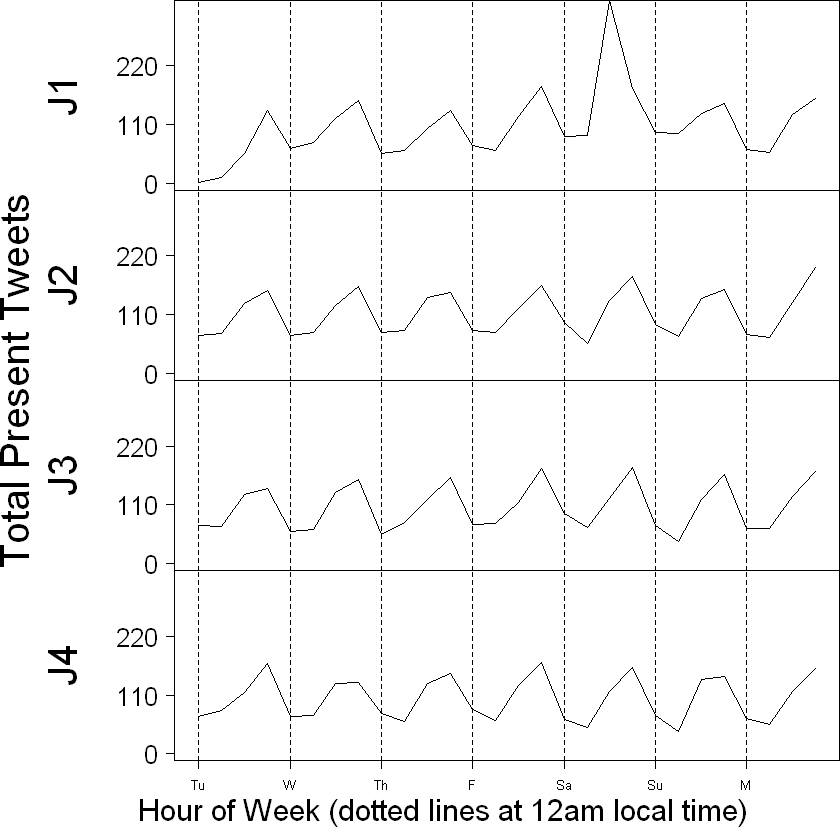

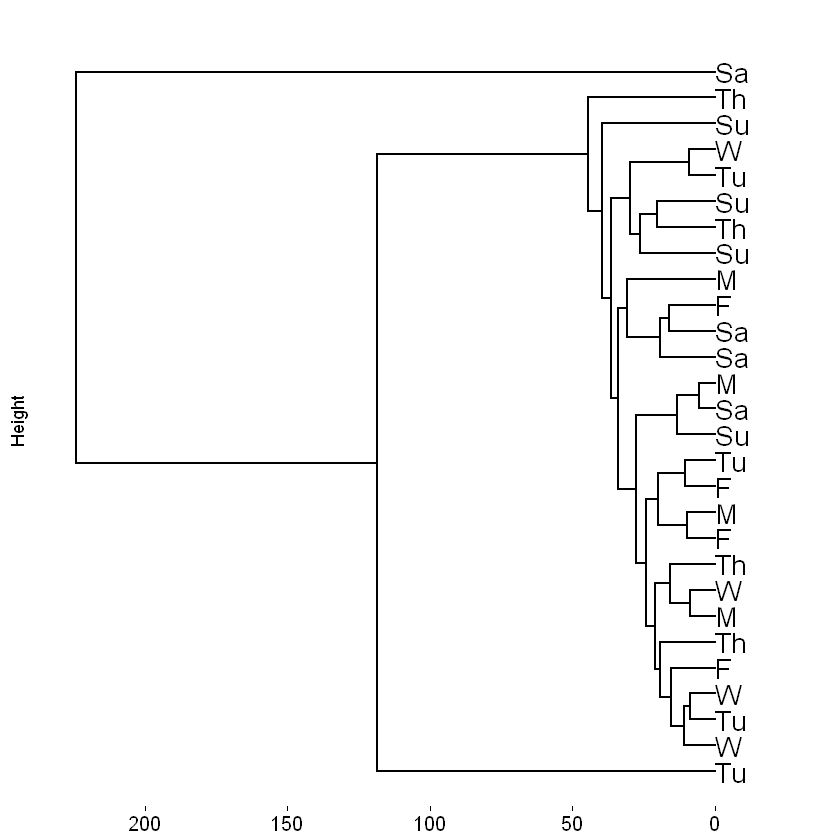

In [117]:
plot_6hour('c:/users/tom/documents/nyu-test/tob-run/june/summary/summary/present.csv', plot_max=330)

# Absolute number of Current tweets per 6 hours in June

integer(0)


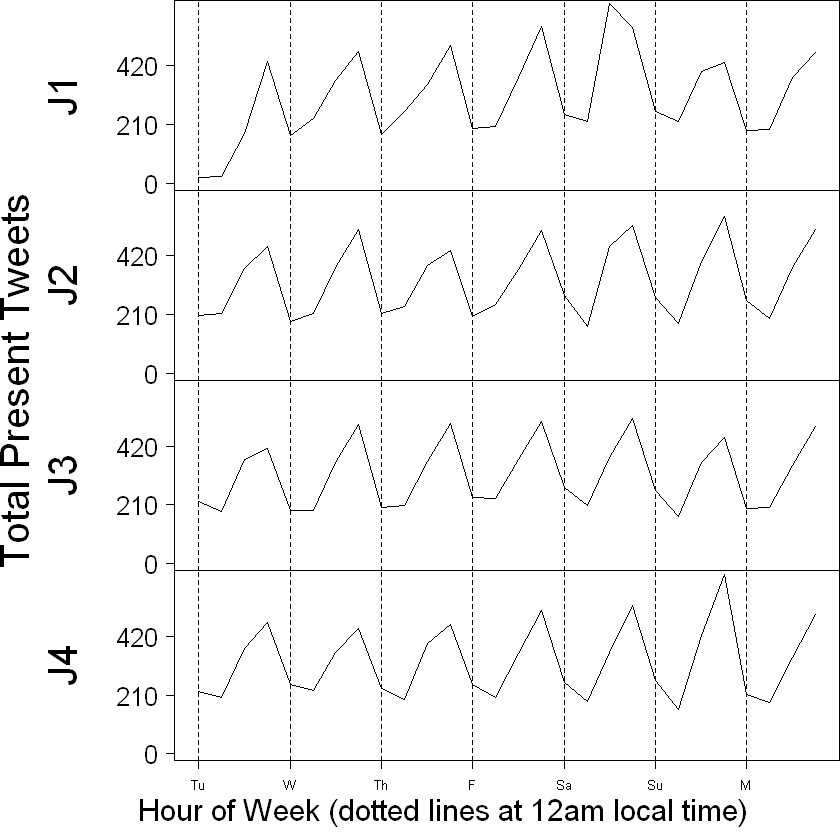

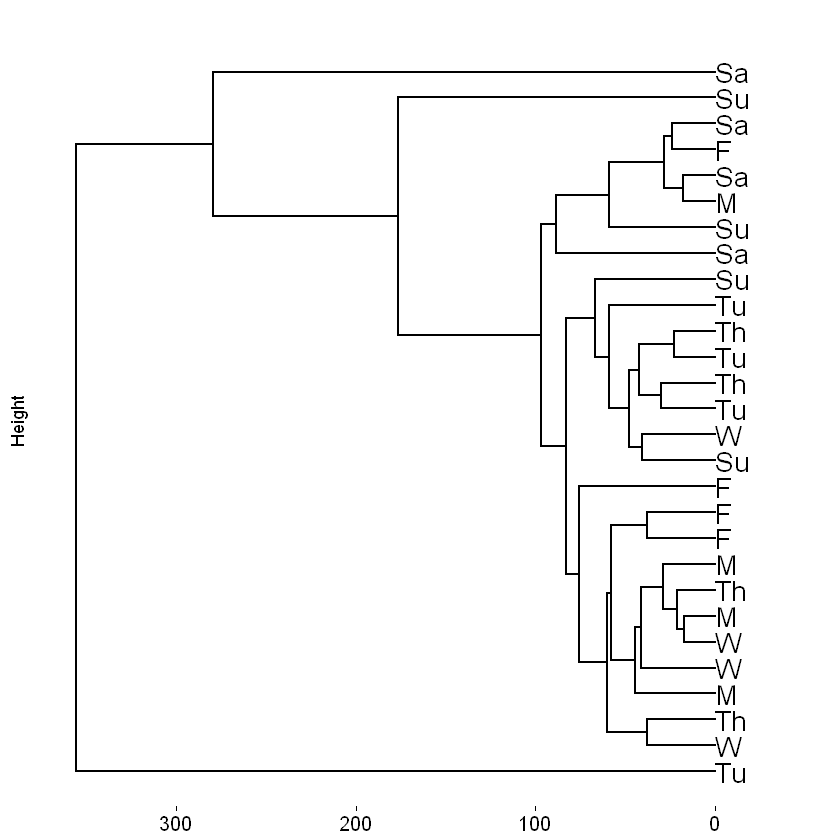

In [119]:
plot_6hour('c:/users/tom/documents/nyu-test/tob-run/june/summary/summary/current.csv', plot_max=630)

# Absolute number of (Shisha and present) tweets per 6 hours in June

integer(0)


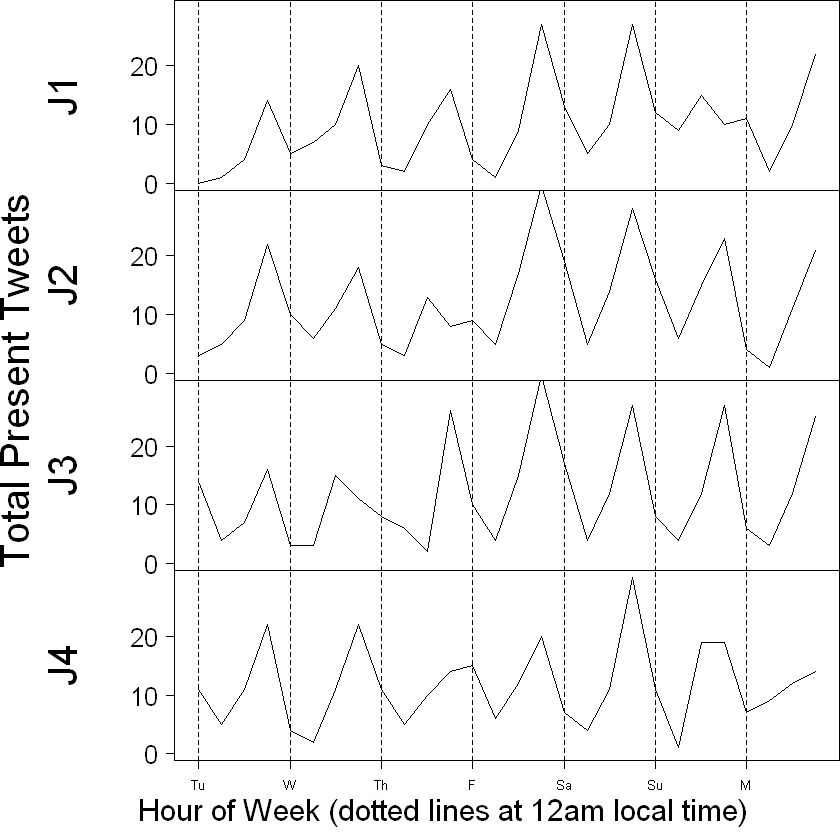

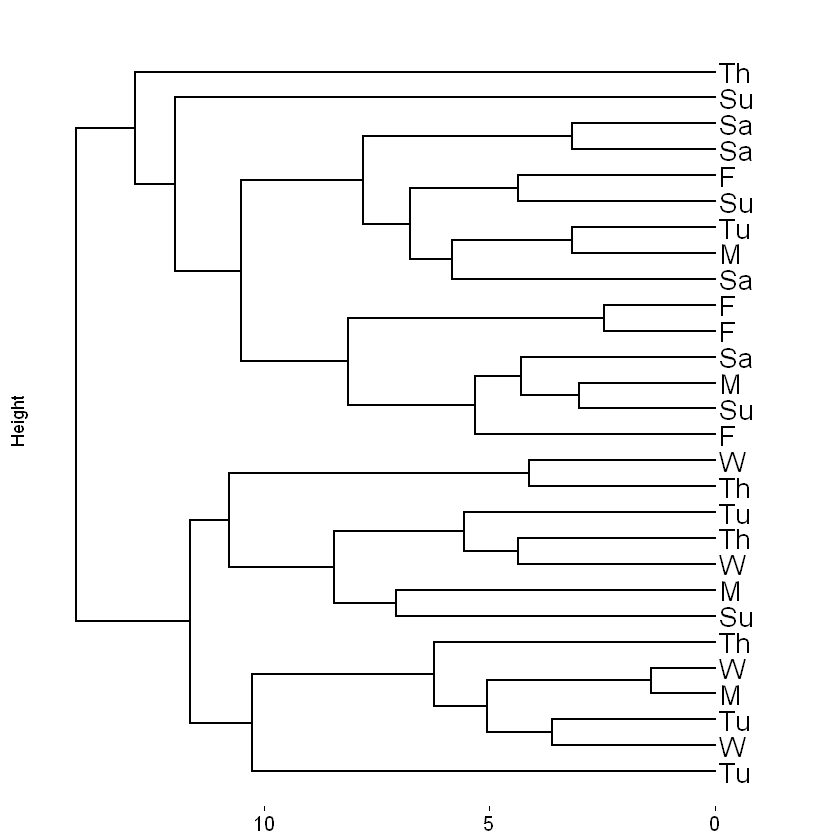

In [121]:
plot_6hour('c:/users/tom/documents/nyu-test/tob-run/june/summary/summary/shisha.csv', plot_max = 30)

In [6]:
j_tob <- read.csv('c:/users/tom/documents/nyu-test/tob-run/june/summary/summary/present.csv')

In [7]:
head(j_tob)

day,hour,sum,len
1,0,0,6004
1,1,2,3852
1,2,0,2415
1,3,0,1762
1,4,0,1648
1,5,0,2091


In [8]:
pres <- j_tob[c(1,2,3)]
tot <- j_tob[c(1,2,4)]

In [9]:
new <- preprocessing_df(pres, tot)

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723


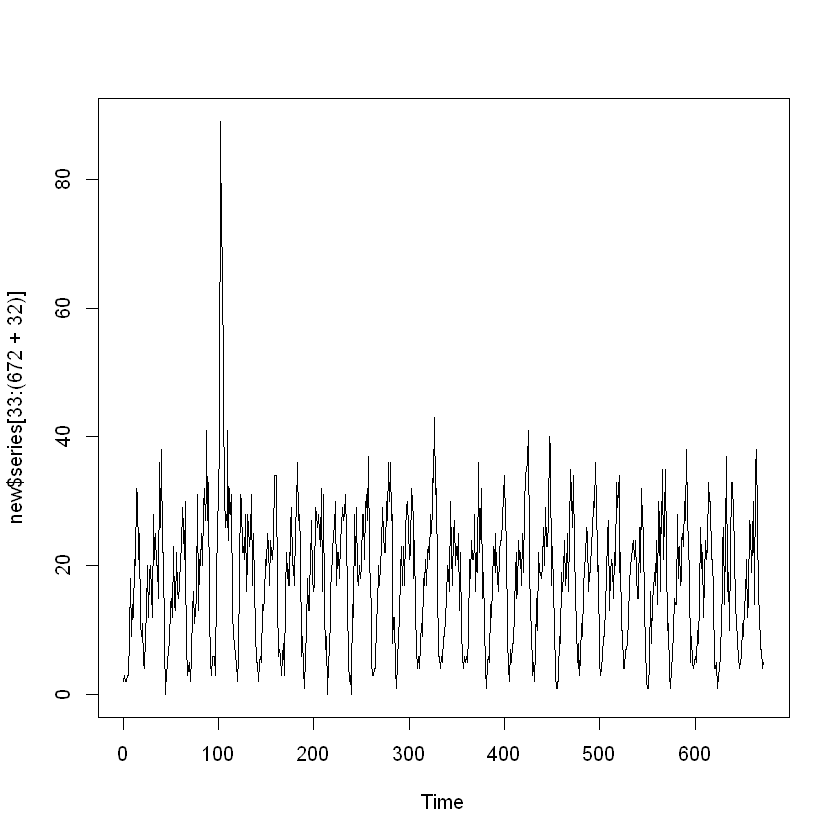

In [10]:
plot.ts(new$series[33:(672+32)])

In [11]:
new_perc <- ts((new$series/new$total)[33:(672+32)], frequency=24)

In [12]:
ts_pres <- ts((new$series)[33:(672+32)], frequency=24)

In [13]:
new.1 = as.numeric(window(new_perc, start=c(1, 1), end= c(7, 24)))
new.2 = as.numeric(window(new_perc, start=c(8, 1), end= c(14, 24)))
new.3 = as.numeric(window(new_perc, start=c(15, 1), end= c(21, 24)))
new.4 = as.numeric(window(new_perc, start=c(22, 1), end= c(28, 24)))
pres.1 = as.numeric(window(ts_pres, start=c(1, 1), end= c(7, 24)))
pres.2 = as.numeric(window(ts_pres, start=c(8, 1), end= c(14, 24)))
pres.3 = as.numeric(window(ts_pres, start=c(15, 1), end= c(21, 24)))
pres.4 = as.numeric(window(ts_pres, start=c(22, 1), end= c(28, 24)))

In [14]:
weeks = data.frame(new.1, new.2, new.3, new.4)
abs_tob = data.frame(pres.1, pres.2, pres.3, pres.4)

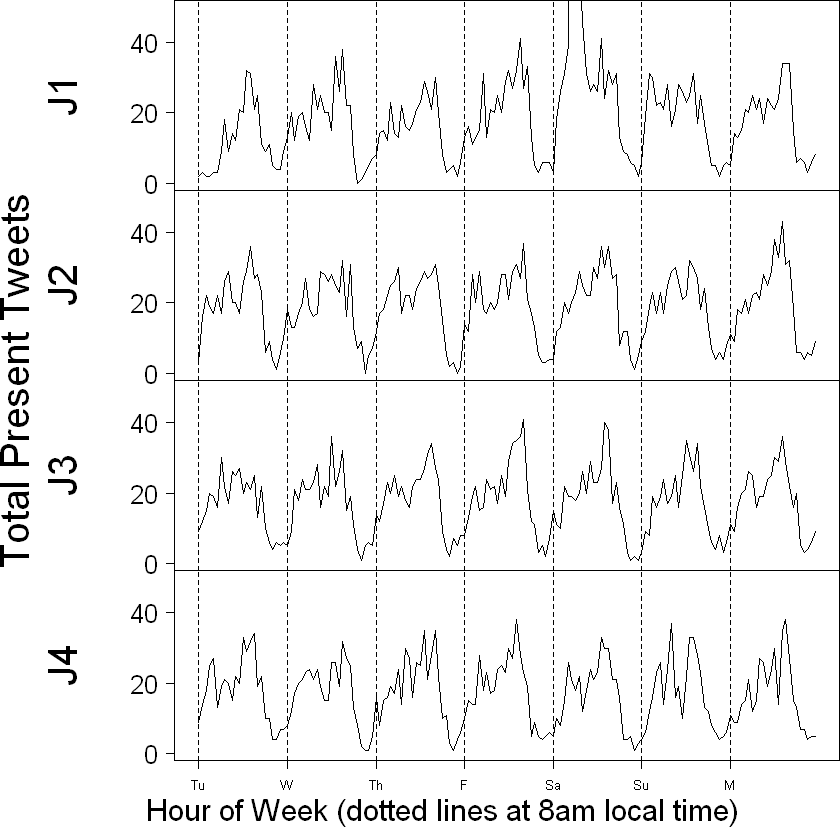

In [27]:
# Absolute number of tweets per hour
plot_weeks <- function(ts){
#     week_names = c('June 2-8', 'June 9-15', 'June 16-22', 'June 23-29', 'Sept 1-7', 'Sept 8-14', 'Sept 15-21', 'Sept 22-28')
    week_names = c('J1', 'J2', 'J3', 'J4')
par(mfrow=c(4,1))
# outer margin
par(oma = c(5, 3, 0, 0))

shade_color <- rgb(0, 0, 190, alpha=50, maxColorValue=255)
for (col in 1:4){
    # remove space for x-axis
    par(mar = c(0, 8, 0, 0))
    yrange = c(0, 50)
    plot(ts[, col], type='l', xaxt='n', ylim=yrange, yaxt='n', ylab='')
    title(cex.lab =3, ylab=week_names[col], line=6)
    axis(2, labels = c('0', '20', '40'), at=c(0, 20, 40), las = 1, cex.axis=2)
    abline(v=seq(1, 168, by=24), lty=2)

}

mtext('Total Present Tweets', cex=2, side = 2, outer = TRUE, line = 1)
mtext('Hour of Week (dotted lines at 8am local time)', cex=1.5, side = 1, outer = TRUE, line = 3)
axis(1, labels = c('Tu', 'W', 'Th', 'F', 'Sa', 'Su', 'M'), at=seq(1, 168, by=24), outer=TRUE)

    
}
plot_weeks(abs_tob)

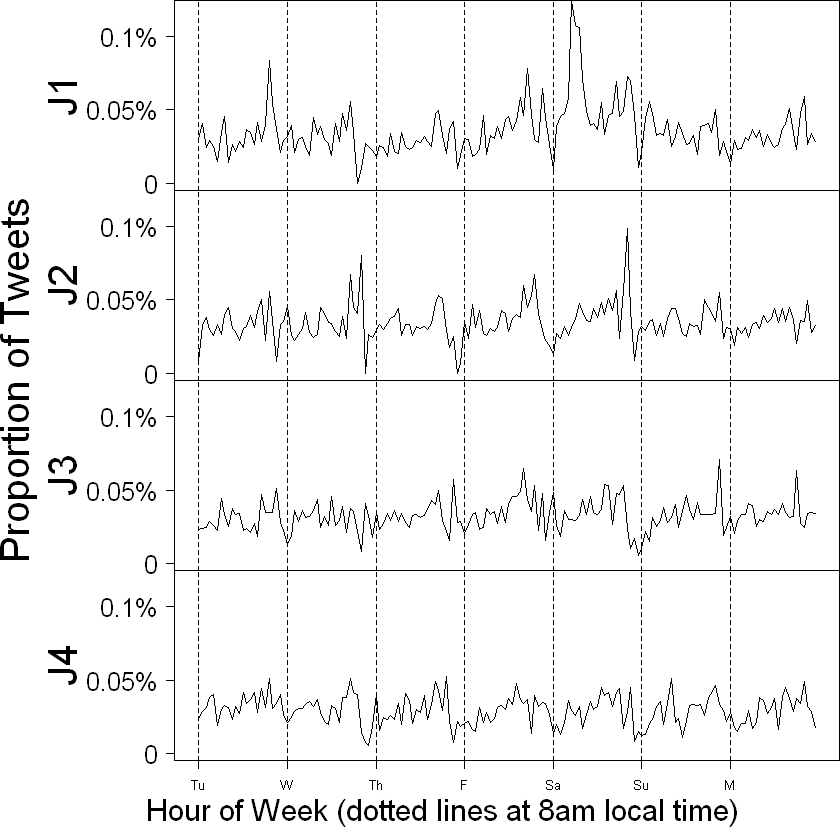

In [17]:
# proportion of tweets per hour
plot_weeks <- function(){
#     week_names = c('June 2-8', 'June 9-15', 'June 16-22', 'June 23-29', 'Sept 1-7', 'Sept 8-14', 'Sept 15-21', 'Sept 22-28')
    week_names = c('J1', 'J2', 'J3', 'J4')
par(mfrow=c(4,1))
# outer margin
par(oma = c(5, 3, 0, 0))

shade_color <- rgb(0, 0, 190, alpha=50, maxColorValue=255)
for (col in 1:4){
    # remove space for x-axis
    par(mar = c(0, 8, 0, 0))
    yrange = c(0, 0.0012)
    plot(weeks[, col], type='l', xaxt='n', ylim=yrange, yaxt='n', ylab='')
    title(cex.lab =3, ylab=week_names[col], line=6)
    axis(2, labels = c('0', '0.05%', '0.1%'), at=c(0, 0.0005, 0.001), las = 1, cex.axis=2)
    abline(v=seq(1, 168, by=24), lty=2)

}

mtext('Proportion of Tweets', cex=2, side = 2, outer = TRUE, line = 1)
mtext('Hour of Week (dotted lines at 8am local time)', cex=1.5, side = 1, outer = TRUE, line = 3)
axis(1, labels = c('Tu', 'W', 'Th', 'F', 'Sa', 'Su', 'M'), at=seq(1, 168, by=24), outer=TRUE)

    
}
plot_weeks()

In [19]:
library('TSclust')

Warning message:
"package 'TSclust' was built under R version 3.3.3"Loading required package: wmtsa
Warning message:
"package 'wmtsa' was built under R version 3.3.3"Loading required package: pdc
Warning message:
"package 'pdc' was built under R version 3.3.3"Loading required package: cluster


In [20]:
library(factoextra)

Warning message:
"package 'factoextra' was built under R version 3.3.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.3.3"

In [21]:
weekdays = rep(c('Tu', 'W' ,'Th', 'F', 'Sa', 'Su', 'M'), 4)

In [22]:
ts_pres

Time Series:
Start = c(1, 1) 
End = c(28, 24) 
Frequency = 24 
  [1]  2  3  2  2  3  3  9 18  9 14 12 21 20 32 31 21 25 11  9 11  5  4  4  9 13
 [26] 20 12 19 20 16 12 28 21 25 20 20 15 36 26 38 22 22  8  0  1  3  5  7  8 14
 [51] 15 12 23 14 13 22 16 15 17 21 23 29 26 21 30 20  8  3  4  5  2  6 13 16 11
 [76] 13 15 31 13 21 20 25 20 29 32 27 32 41 27 33 13  5  3  6  6  6  3 18 26 31
[101] 39 89 70 69 46 31 26 28 26 41 24 32 28 31 13  9  8  6  5  2  6 19 31 30 22
[126] 23 21 28 16 21 28 26 23 25 31 17 25 17 10  5  5  2  5  6  5 14 13 15 21 20
[151] 25 21 24 17 24 22 21 24 34 34 34 15  6  7  6  3  6  8  3 16 22 19 17 22 17
[176] 26 29 20 20 17 26 29 36 27 28 23  6  9  4  1  6 10 18 13 13 17 20 27 18 16
[201] 17 29 28 26 28 25 23 32 16 31 13  7  9  0  5  7 12 17 18 22 25 26 30 17 22
[226] 22 18 24 26 29 27 28 31 25 15  5  2  3  0  2 14 12 28 20 29 18 17 20 18 20
[251] 28 28 21 29 31 27 37 21 17 13  5  3  3  4  4 12 13 20 17 20 23 29 25 22 22
[276] 30 27 36 30 36 27 28  8 12 12  4  1  5  

In [23]:
june_days = split_by_day(new_perc)
colnames(june_days)=weekdays
dist = diss(june_days, METHOD = 'EUCL')
b = agnes(dist, diss=TRUE)

Percentage of total tweets time series dendogram:

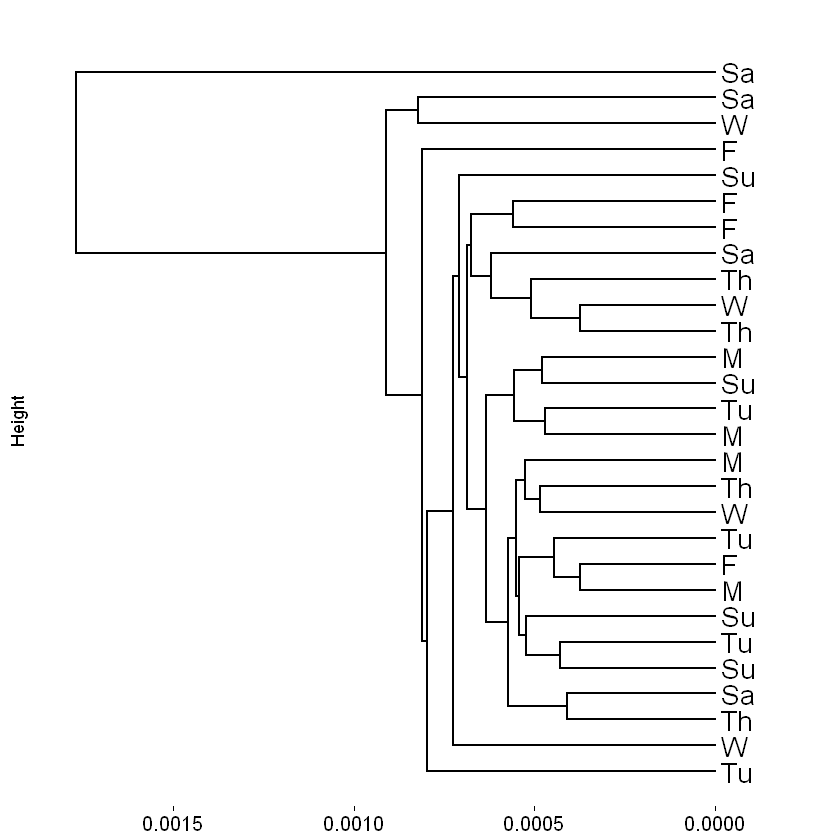

In [24]:
euc_dend <-function(){
    fviz_dend(b, rect=TRUE, main='', ylab='', xlab='Height', 
              las=1, cex=1.2, cex.lab=1.5, horiz=TRUE)
    #mtext( text='Day of Week', side=2, cex=1.5)
}
euc_dend()

Absolute number of tweets per hour time series:

In [25]:
june_days = split_by_day(ts_pres)
colnames(june_days)=weekdays
dist = diss(june_days, METHOD = 'EUCL')
c = agnes(dist, diss=TRUE)

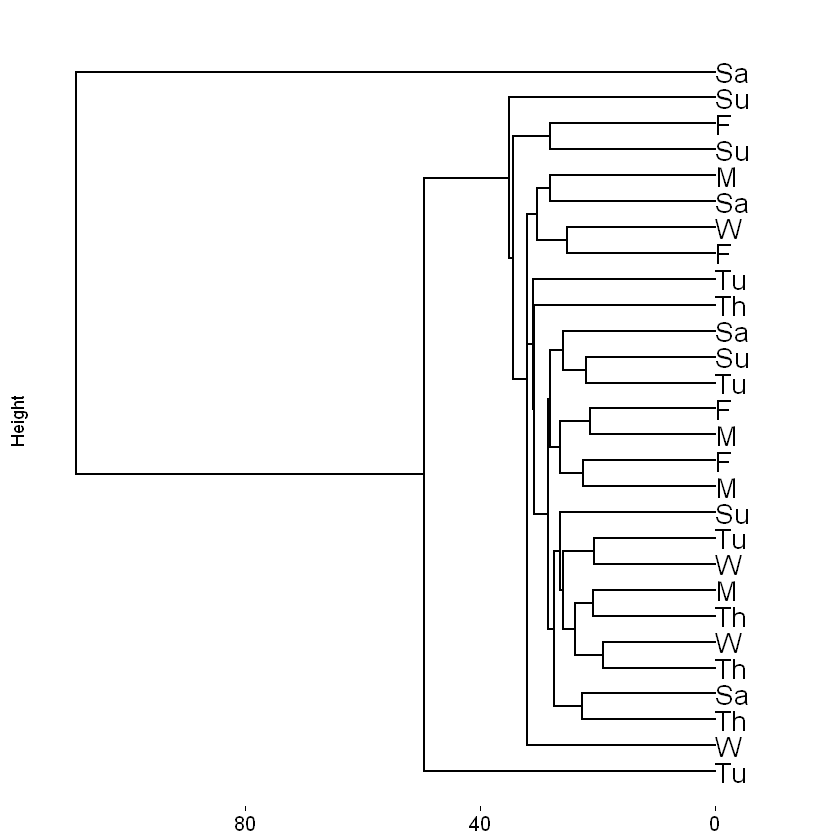

In [26]:
euc_dend <-function(){
    fviz_dend(c, rect=TRUE, main='', ylab='', xlab='Height', 
              las=1, cex=1.2, cex.lab=1.5, horiz=TRUE)
    #mtext( text='Day of Week', side=2, cex=1.5)
}
euc_dend()